In [1]:
import warnings
warnings.filterwarnings('ignore')

#Data preparation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#Label encoding
from sklearn import preprocessing

#Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_clients = pd.read_csv("dataset.csv", delimiter = ';')

In [3]:
#Check for duplicates:
df_clients.duplicated().sum()

0

In [4]:
df_clients.info()
#There are numerical features with object as type. - These columns should be converted before doing any operation.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   object 
 1   mou_Mean          99643 non-null   object 
 2   totmrc_Mean       99643 non-null   object 
 3   da_Mean           99643 non-null   object 
 4   ovrmou_Mean       99643 non-null   object 
 5   ovrrev_Mean       99643 non-null   object 
 6   vceovr_Mean       99643 non-null   object 
 7   datovr_Mean       99643 non-null   object 
 8   roam_Mean         99643 non-null   object 
 9   change_mou        99109 non-null   object 
 10  change_rev        99109 non-null   object 
 11  drop_vce_Mean     100000 non-null  object 
 12  drop_dat_Mean     100000 non-null  object 
 13  blck_vce_Mean     100000 non-null  object 
 14  blck_dat_Mean     100000 non-null  object 
 15  unan_vce_Mean     100000 non-null  object 
 16  unan_dat_Mean     10

In [5]:
#The target column is not unbalanced.
df_clients.groupby('churn')['churn'].count()

churn
0    50438
1    49562
Name: churn, dtype: int64

In [6]:
#We are going to drop the columns with more than 35% of nan values once it will not contribute to the target prediction.

pre_nan = df_clients.isnull().sum().reset_index()
pre_nan = pre_nan.rename(columns={"index": "col_name", 0: "nan_num"})
pre_nan["nan_per"] = (pre_nan.nan_num / df_clients.shape[0]) * 100

df_nan = pre_nan[pre_nan.nan_per > 35]
df_nan

#We are going to remove the following columns: numbcars, HHstatin and dwllsize.

,col_name,nan_num,nan_per
87,numbcars,49366,49.366
88,HHstatin,37923,37.923
89,dwllsize,38308,38.308


In [7]:
#Drpping columns with more than 35% of nan values.
df_clients = df_clients.drop(["numbcars", "HHstatin", "dwllsize"], axis = 1)
# We are left with 96 columns from now on.

In [9]:
#Separate the features between, numerical, categorical and target.

numerical_feat = df_clients[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean',
                             'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean',
                             'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 
                             'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
                             'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'uniqsubs', 'actvsubs', 'months', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou',
                             'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'hnd_price', 'phones', 'models', 'lor', 'adults', 'income', 'eqpdays']]

categorical_feat = df_clients[['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new',  'hnd_webcap', 'truck', 'rv', 'ownrent', 'dwlltype', 'marital', 'infobase', 'forgntvl', 
                               'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']]

target = df_clients.churn

In [10]:
numerical_feat.head(10)
#Let's start by replacing the commas by dots.

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,lor,adults,income,eqpdays
0,"23,9975","219,25","22,5","0,2475",0,0,0,0,0,"-157,25",...,322.0,136.0,38.0,"149,9899902",2.0,2.0,15.0,1.0,4.0,361.0
1,"57,4925","482,75","37,425","0,2475","22,75","9,1","9,1",0,0,"532,25",...,477.0,275.0,48.0,NaN,7.0,6.0,1.0,1.0,5.0,240.0
2,"16,99","10,25","16,99",0,0,0,0,0,0,"-4,25",...,11.0,6.0,17.0,"29,98999023",2.0,1.0,7.0,2.0,5.0,1504.0
3,38,"7,5",38,0,0,0,0,0,0,"-1,5",...,50.0,25.0,40.0,"29,98999023",1.0,1.0,6.0,4.0,6.0,1812.0
4,"55,23","570,5","71,98",0,0,0,0,0,0,"38,5",...,586.0,196.0,80.0,"149,9899902",6.0,4.0,5.0,1.0,6.0,434.0
5,"82,275","1312,25",75,"1,2375",0,0,0,0,0,"156,75",...,1187.0,853.0,78.0,"129,9899902",9.0,4.0,1.0,1.0,6.0,458.0
6,"17,145",0,"16,99",0,0,0,0,0,0,0,...,0.0,0.0,17.0,"29,98999023",4.0,3.0,8.0,3.0,9.0,852.0
7,"38,0525","682,5","52,49","0,2475",0,0,0,0,0,"147,5",...,719.0,112.0,58.0,"79,98999023",3.0,2.0,0.0,2.0,1.0,231.0
8,"97,3375",1039,50,"4,95","419,5","41,95","41,95",0,0,198,...,915.0,434.0,90.0,"29,98999023",3.0,3.0,3.0,3.0,4.0,700.0
9,"31,6625","25,5","29,99","0,2475",0,0,0,0,0,"59,5",...,54.0,7.0,34.0,"79,98999023",2.0,2.0,8.0,2.0,9.0,601.0


In [11]:
#Transform all columns into object type
numerical_feat_object = numerical_feat.astype(str)

#Replace the commas with dots
numerical_feat_prep = numerical_feat_object.apply(lambda x: x.str.replace(',','.'))

#Replace all nan string with nan type
numerical_feat_prep = numerical_feat_prep.replace('nan',np.nan)

#Re-transform all columns back to numerical type
numerical_feat = numerical_feat_prep.apply(pd.to_numeric, errors = 'raise')

#numerical_feat.info()

In [12]:
#Replace all nan values with the respective means.
numerical_feat_final = numerical_feat.fillna(numerical_feat.mean())
#numerical_feat_final.isnull().sum()

In [13]:
#Arrange categorical variables.
categorical_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   new_cell          100000 non-null  object 
 1   crclscod          100000 non-null  object 
 2   asl_flag          100000 non-null  object 
 3   prizm_social_one  92612 non-null   object 
 4   area              99960 non-null   object 
 5   dualband          99999 non-null   object 
 6   refurb_new        99999 non-null   object 
 7   hnd_webcap        89811 non-null   object 
 8   truck             98268 non-null   float64
 9   rv                98268 non-null   float64
 10  ownrent           66294 non-null   object 
 11  dwlltype          68091 non-null   object 
 12  marital           98268 non-null   object 
 13  infobase          77921 non-null   object 
 14  forgntvl          98268 non-null   float64
 15  ethnic            98268 non-null   object 
 16  kid0_2            982

In [14]:
#Fill nan values with mode.
fill_mode = lambda col: col.fillna(col.mode()[0])

#It will go like this:
#First we replace the area colum with the mode.
categorical_feat.area = categorical_feat.area.fillna(categorical_feat.area.mode()[0])

#Then, we replace the columns which the mode differs by area. These are: prizm_social_one, marital, ethnic and dwlltype
#Here the code line I used to figure this out:
#test = categorical_feat.groupby("area").agg(pd.Series.mode).reset_index()
#test.tail(20)

categorical_feat.prizm_social_one = categorical_feat.groupby(['area'], sort = False)['prizm_social_one'].apply(fill_mode)
categorical_feat.marital = categorical_feat.groupby(['area'], sort = False)['marital'].apply(fill_mode)
categorical_feat.ethnic = categorical_feat.groupby(['area'], sort = False)['ethnic'].apply(fill_mode)
categorical_feat.dwlltype = categorical_feat.groupby(['area'], sort = False)['dwlltype'].apply(fill_mode)

#Lastly, we fill the remaining nan values with the mode without considering the grouped data by area.
categorical_feat_prep = categorical_feat.apply(fill_mode, axis = 0)
categorical_feat_prep.head(10)
#categorical_feat_prep.isnull().sum()

,new_cell,crclscod,asl_flag,prizm_social_one,area,dualband,refurb_new,hnd_webcap,truck,rv,...,marital,infobase,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd
0,U,A,N,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,WCMB,0.0,0.0,...,S,M,0.0,N,U,U,U,U,U,Y
1,N,EA,N,U,CHICAGO AREA,N,N,WC,1.0,1.0,...,S,M,0.0,Z,U,U,U,U,U,Y
2,Y,C,N,S,GREAT LAKES AREA,N,N,WCMB,0.0,0.0,...,M,M,0.0,N,U,Y,U,U,U,Y
3,Y,B,N,T,CHICAGO AREA,N,N,WCMB,0.0,0.0,...,M,M,0.0,U,Y,U,U,U,U,Y
4,Y,A,N,U,NEW ENGLAND AREA,Y,N,WCMB,0.0,0.0,...,S,M,0.0,I,U,U,U,U,U,Y
5,Y,C,N,U,GREAT LAKES AREA,N,N,WCMB,0.0,0.0,...,S,M,0.0,U,U,U,U,U,U,Y
6,N,A,N,C,DALLAS AREA,Y,N,WCMB,0.0,0.0,...,M,M,0.0,N,U,U,U,U,U,Y
7,Y,B,N,S,DALLAS AREA,Y,N,WCMB,0.0,0.0,...,M,M,1.0,S,U,U,U,U,U,Y
8,Y,B,N,S,CHICAGO AREA,Y,N,WCMB,0.0,0.0,...,M,M,0.0,F,U,U,U,U,U,N
9,N,A,N,C,DALLAS AREA,Y,N,WCMB,0.0,0.0,...,M,M,1.0,N,U,U,U,U,U,Y


In [15]:
#Let's now reduce the 5 kids variables into one.
#We are going to create a single column that it has value Y if the household has kids or N if it does not have kids.
#We are also going to assume that if it's U (unknown) than it has not kids (N).

categorical_feat_prep['kids_in_household'] = np.where((categorical_feat_prep.kid0_2 == "Y") | 
                                                      (categorical_feat_prep.kid3_5 == "Y") | 
                                                      (categorical_feat_prep.kid6_10 == "Y") | 
                                                      (categorical_feat_prep.kid11_15 == "Y") | 
                                                      (categorical_feat_prep.kid16_17 == "Y"), "Y", "N")

#Drop unnecessary kids columns.
categorical_feat_final = categorical_feat_prep.drop(['kid0_2','kid3_5', 'kid6_10', 'kid11_15', 'kid16_17'], axis = 1)
#From now on, we have 18 categorical variables.
#categorical_feat_final.shape

In [16]:
#Check the outliers for the numerical variables.
numerical_feat_final.describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,lor,adults,income,eqpdays
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,58.719985,513.559937,46.179136,0.888828,41.072247,13.559560,13.295062,0.261318,1.286405,-13.933818,...,509.634576,178.365157,58.683618,101.875763,1.787118,1.545825,6.177238,2.530326,5.783112,391.932309
std,46.208972,524.229868,23.581283,2.173729,97.122320,30.446392,30.002391,3.120946,14.685090,274.854774,...,489.562483,180.112088,40.175838,60.746760,1.313971,0.898391,3.956420,1.274685,1.884277,256.480910
min,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,...,0.000000,0.000000,-2.000000,9.989998,1.000000,1.000000,0.000000,1.000000,1.000000,-5.000000
25%,33.311875,151.500000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-86.000000,...,168.000000,61.000000,35.000000,29.989990,1.000000,1.000000,3.000000,2.000000,5.000000,212.000000
50%,48.377500,357.500000,44.990000,0.247500,3.000000,1.050000,0.700000,0.000000,0.000000,-7.000000,...,377.000000,132.000000,50.000000,99.989990,1.000000,1.000000,6.177238,2.530326,5.783112,342.000000
75%,70.630000,701.250000,59.990000,0.888828,42.000000,14.350000,13.950000,0.000000,0.257500,61.750000,...,683.000000,232.000000,70.000000,149.989990,2.000000,2.000000,7.000000,3.000000,7.000000,530.000000
max,3843.262500,12206.750000,409.990000,159.390000,4320.750000,1102.400000,896.087500,423.540000,3685.200000,31219.250000,...,7217.000000,3256.000000,866.000000,499.989990,28.000000,16.000000,15.000000,6.000000,9.000000,1823.000000


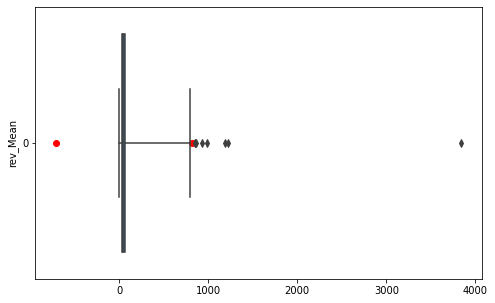

Lower limit of rev_Mean is -713.0
Upper limit of rev_Mean is 817.0


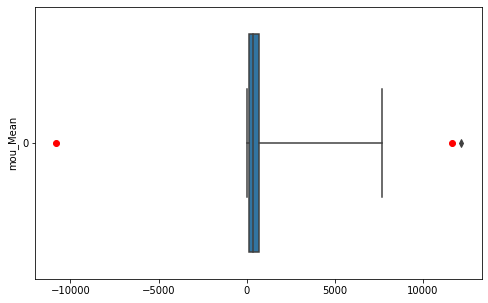

Lower limit of mou_Mean is -10844.0
Upper limit of mou_Mean is 11696.0


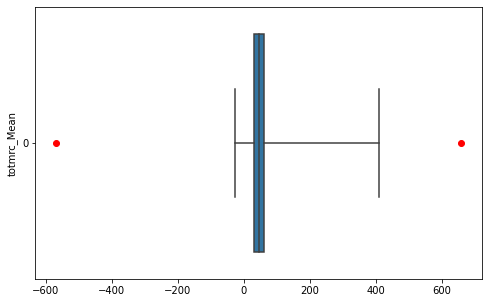

Lower limit of totmrc_Mean is -570.0
Upper limit of totmrc_Mean is 660.0


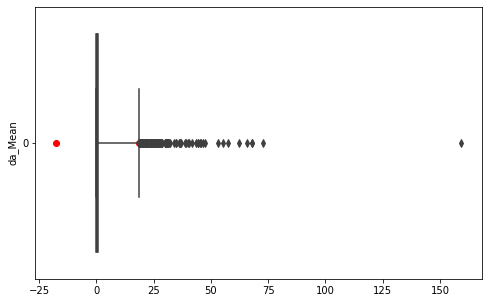

Lower limit of da_Mean is -18.0
Upper limit of da_Mean is 19.0


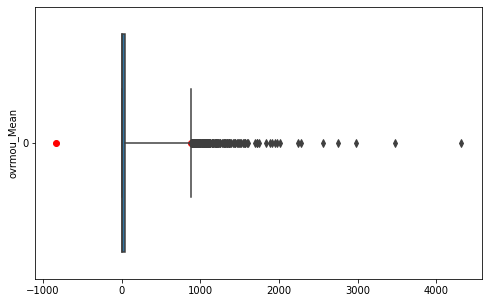

Lower limit of ovrmou_Mean is -840.0
Upper limit of ovrmou_Mean is 882.0


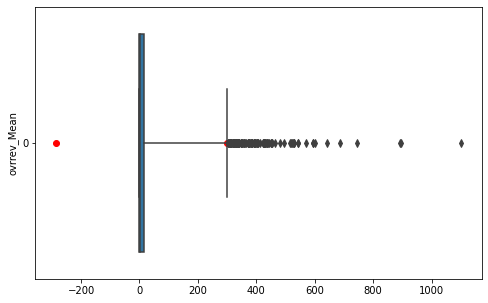

Lower limit of ovrrev_Mean is -287.0
Upper limit of ovrrev_Mean is 301.0


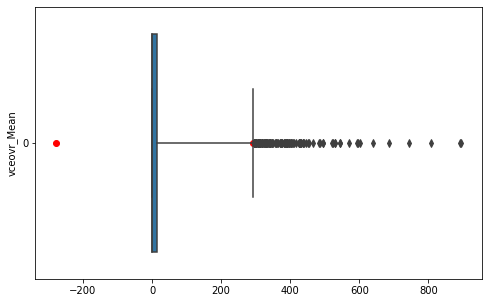

Lower limit of vceovr_Mean is -279.0
Upper limit of vceovr_Mean is 293.0


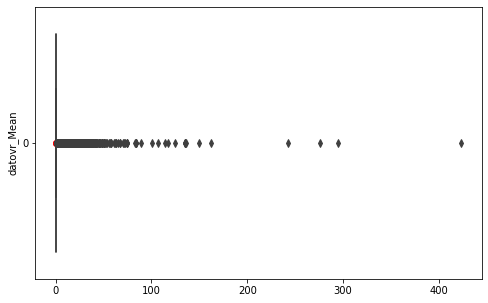

Lower limit of datovr_Mean is 0.0
Upper limit of datovr_Mean is 0.0


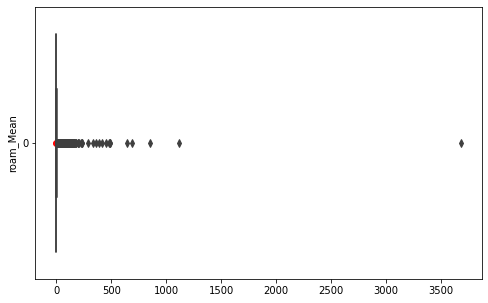

Lower limit of roam_Mean is -5.0
Upper limit of roam_Mean is 5.0


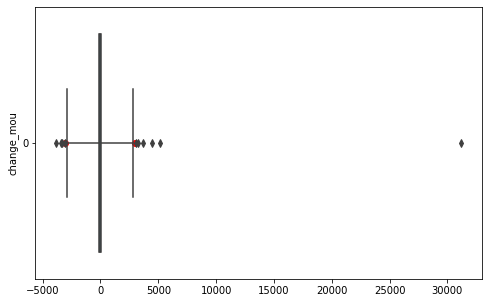

Lower limit of change_mou is -3041.0
Upper limit of change_mou is 3017.0


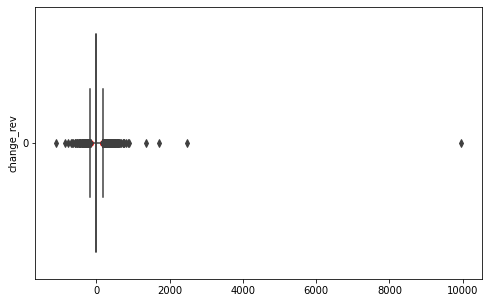

Lower limit of change_rev is -182.0
Upper limit of change_rev is 177.0


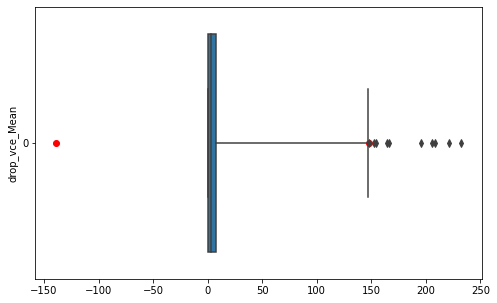

Lower limit of drop_vce_Mean is -139.0
Upper limit of drop_vce_Mean is 148.0


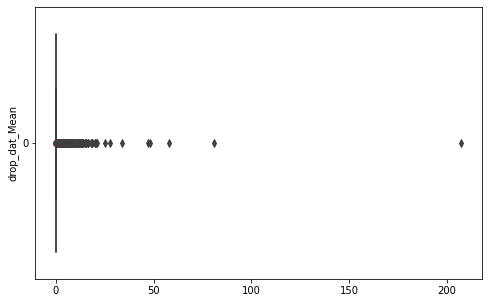

Lower limit of drop_dat_Mean is 0.0
Upper limit of drop_dat_Mean is 0.0


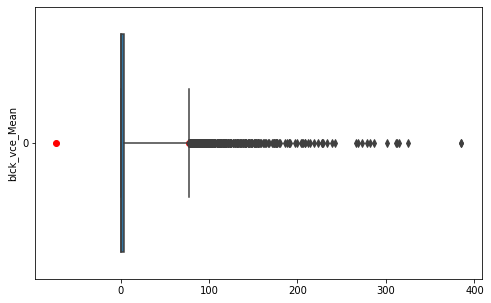

Lower limit of blck_vce_Mean is -73.0
Upper limit of blck_vce_Mean is 77.0


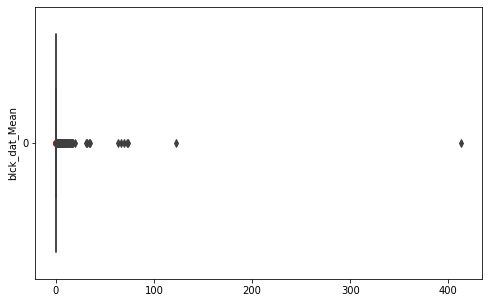

Lower limit of blck_dat_Mean is 0.0
Upper limit of blck_dat_Mean is 0.0


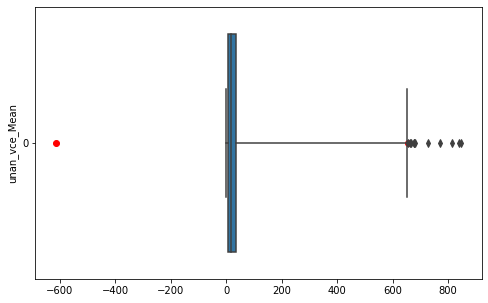

Lower limit of unan_vce_Mean is -615.0
Upper limit of unan_vce_Mean is 656.0


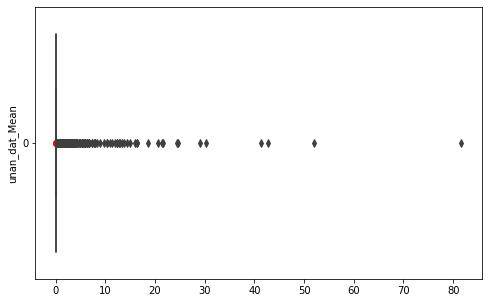

Lower limit of unan_dat_Mean is 0.0
Upper limit of unan_dat_Mean is 0.0


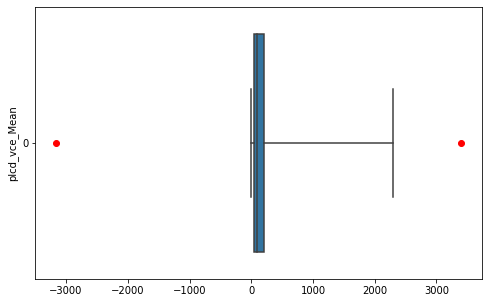

Lower limit of plcd_vce_Mean is -3168.0
Upper limit of plcd_vce_Mean is 3405.0


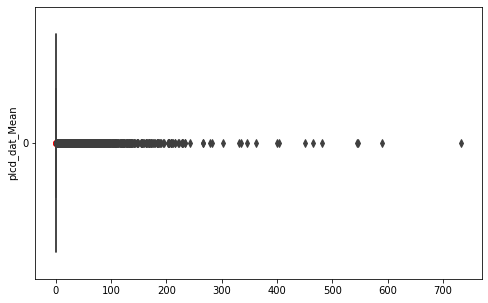

Lower limit of plcd_dat_Mean is 0.0
Upper limit of plcd_dat_Mean is 0.0


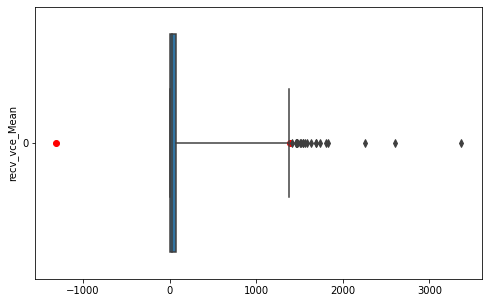

Lower limit of recv_vce_Mean is -1315.0
Upper limit of recv_vce_Mean is 1391.0


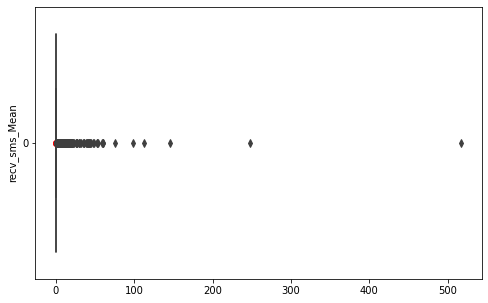

Lower limit of recv_sms_Mean is 0.0
Upper limit of recv_sms_Mean is 0.0


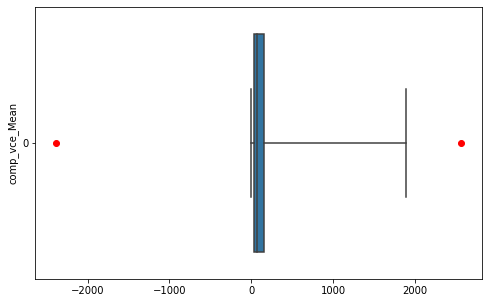

Lower limit of comp_vce_Mean is -2391.0
Upper limit of comp_vce_Mean is 2570.0


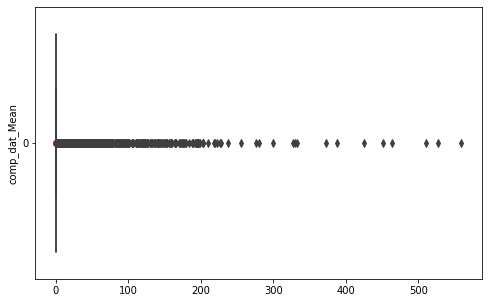

Lower limit of comp_dat_Mean is 0.0
Upper limit of comp_dat_Mean is 0.0


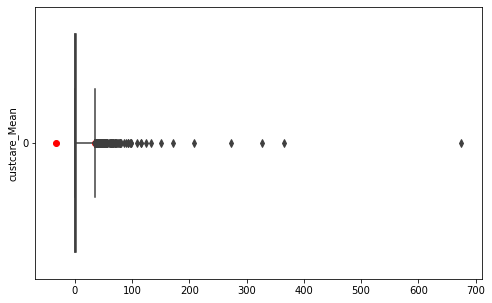

Lower limit of custcare_Mean is -33.0
Upper limit of custcare_Mean is 35.0


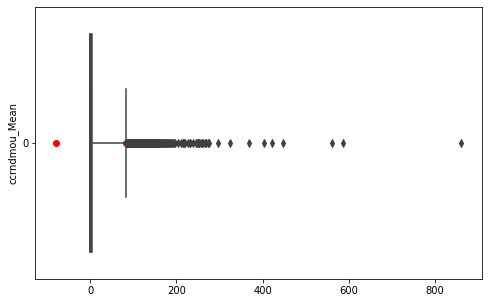

Lower limit of ccrndmou_Mean is -80.0
Upper limit of ccrndmou_Mean is 84.0


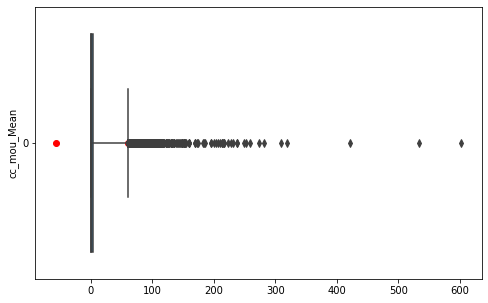

Lower limit of cc_mou_Mean is -57.0
Upper limit of cc_mou_Mean is 60.0


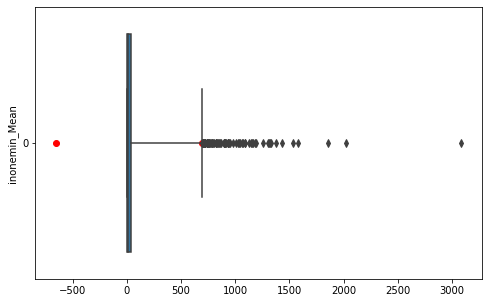

Lower limit of inonemin_Mean is -657.0
Upper limit of inonemin_Mean is 696.0


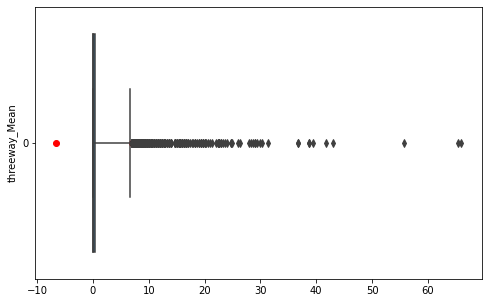

Lower limit of threeway_Mean is -7.0
Upper limit of threeway_Mean is 7.0


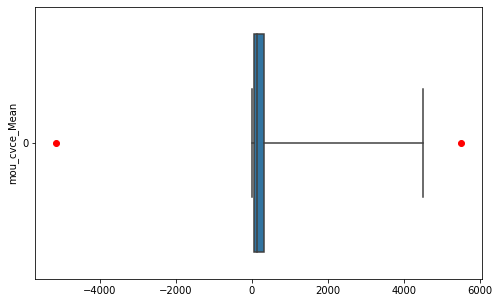

Lower limit of mou_cvce_Mean is -5159.0
Upper limit of mou_cvce_Mean is 5518.0


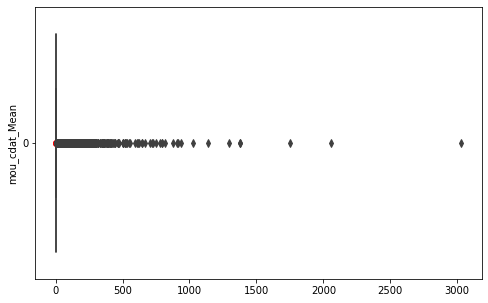

Lower limit of mou_cdat_Mean is 0.0
Upper limit of mou_cdat_Mean is 0.0


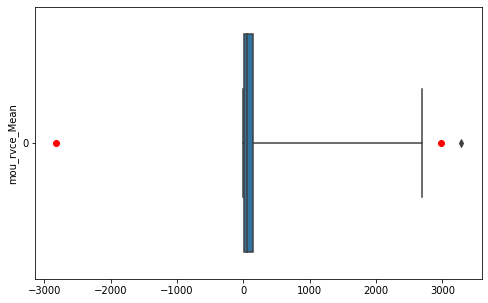

Lower limit of mou_rvce_Mean is -2828.0
Upper limit of mou_rvce_Mean is 2986.0


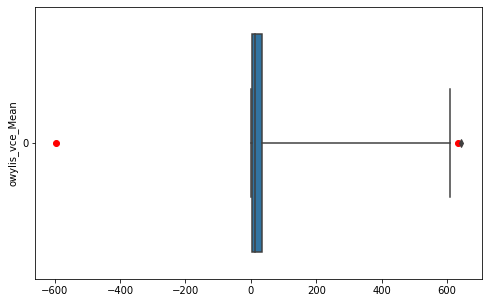

Lower limit of owylis_vce_Mean is -597.0
Upper limit of owylis_vce_Mean is 633.0


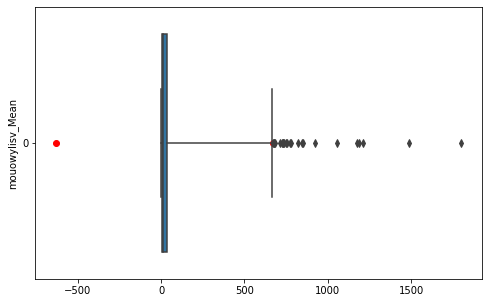

Lower limit of mouowylisv_Mean is -634.0
Upper limit of mouowylisv_Mean is 670.0


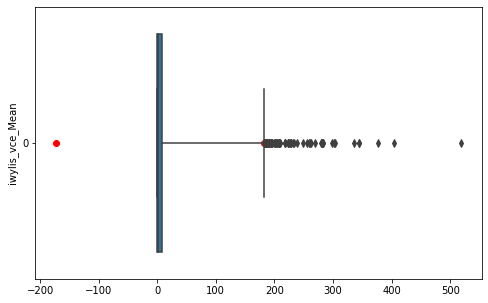

Lower limit of iwylis_vce_Mean is -173.0
Upper limit of iwylis_vce_Mean is 182.0


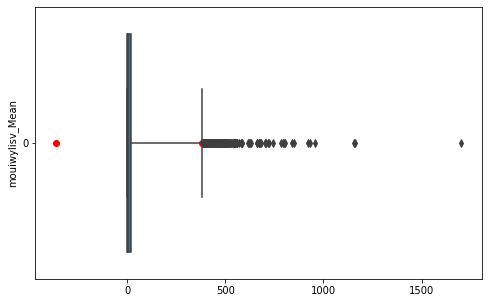

Lower limit of mouiwylisv_Mean is -365.0
Upper limit of mouiwylisv_Mean is 383.0


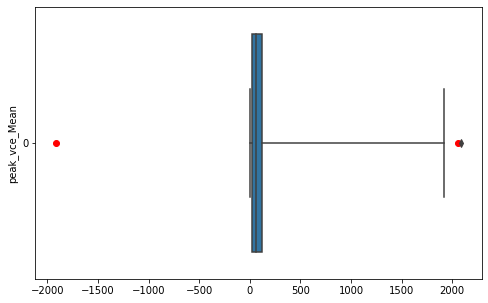

Lower limit of peak_vce_Mean is -1918.0
Upper limit of peak_vce_Mean is 2059.0


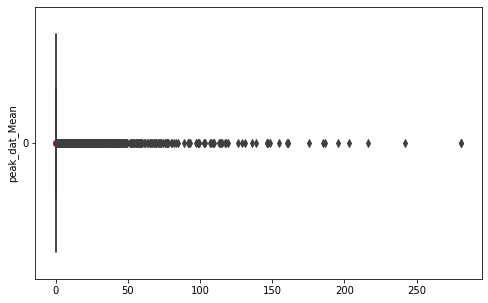

Lower limit of peak_dat_Mean is 0.0
Upper limit of peak_dat_Mean is 0.0


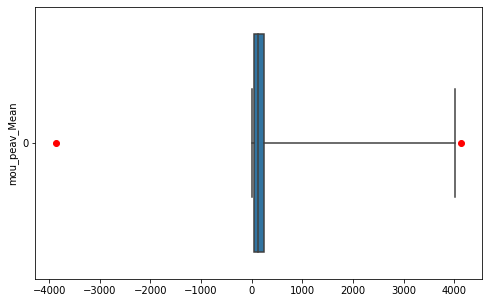

Lower limit of mou_peav_Mean is -3874.0
Upper limit of mou_peav_Mean is 4145.0


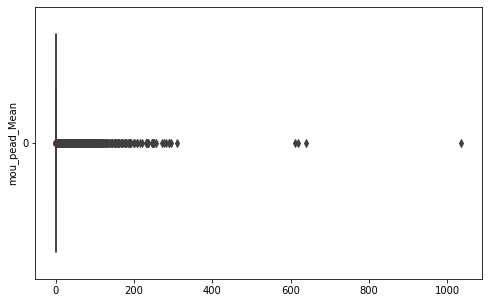

Lower limit of mou_pead_Mean is 0.0
Upper limit of mou_pead_Mean is 0.0


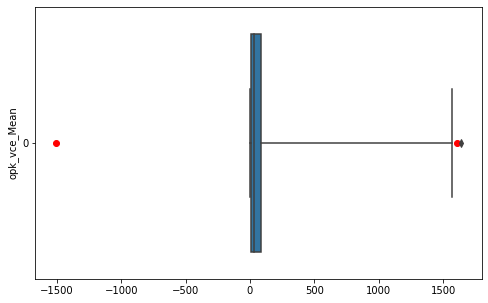

Lower limit of opk_vce_Mean is -1510.0
Upper limit of opk_vce_Mean is 1606.0


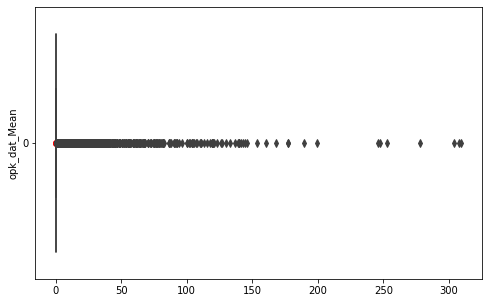

Lower limit of opk_dat_Mean is 0.0
Upper limit of opk_dat_Mean is 0.0


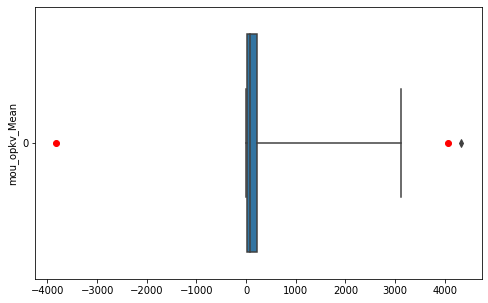

Lower limit of mou_opkv_Mean is -3835.0
Upper limit of mou_opkv_Mean is 4064.0


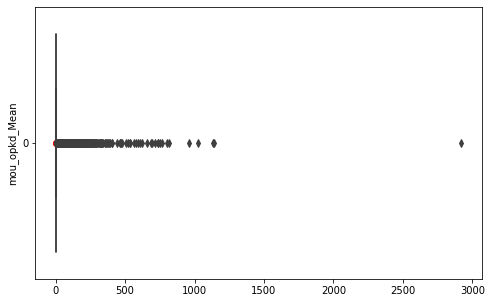

Lower limit of mou_opkd_Mean is 0.0
Upper limit of mou_opkd_Mean is 0.0


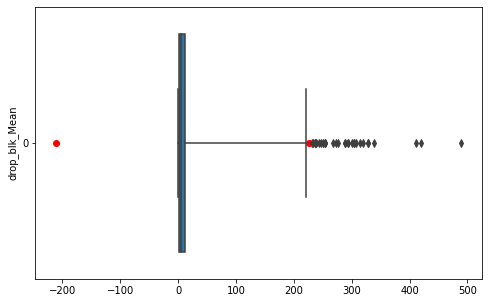

Lower limit of drop_blk_Mean is -212.0
Upper limit of drop_blk_Mean is 226.0


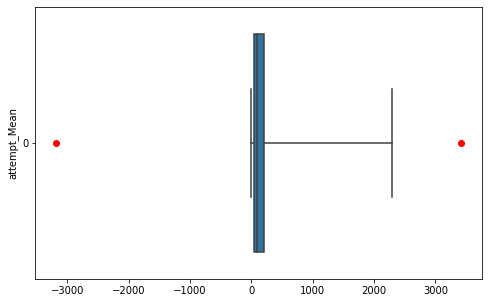

Lower limit of attempt_Mean is -3188.0
Upper limit of attempt_Mean is 3426.0


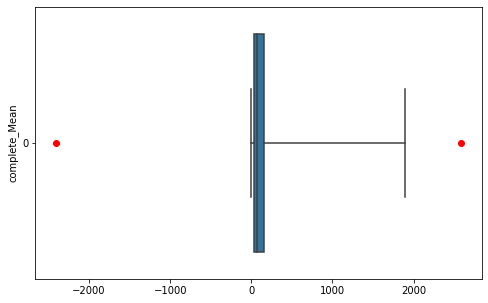

Lower limit of complete_Mean is -2411.0
Upper limit of complete_Mean is 2591.0


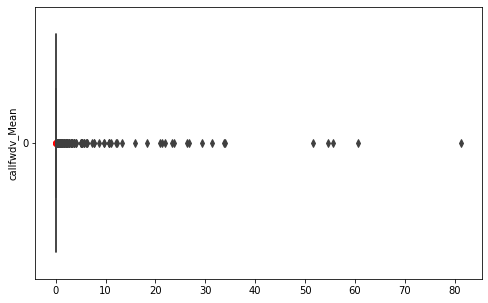

Lower limit of callfwdv_Mean is 0.0
Upper limit of callfwdv_Mean is 0.0


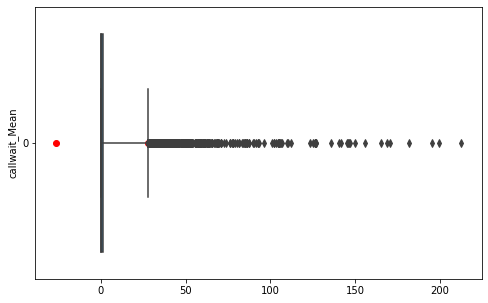

Lower limit of callwait_Mean is -27.0
Upper limit of callwait_Mean is 28.0


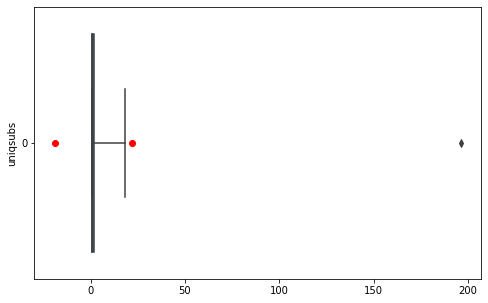

Lower limit of uniqsubs is -19.0
Upper limit of uniqsubs is 22.0


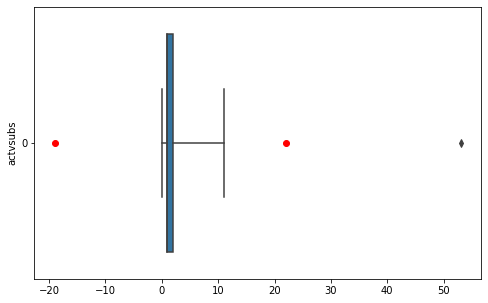

Lower limit of actvsubs is -19.0
Upper limit of actvsubs is 22.0


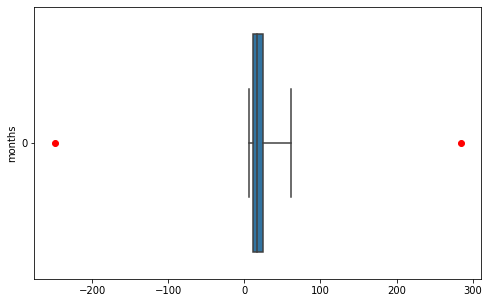

Lower limit of months is -249.0
Upper limit of months is 284.0


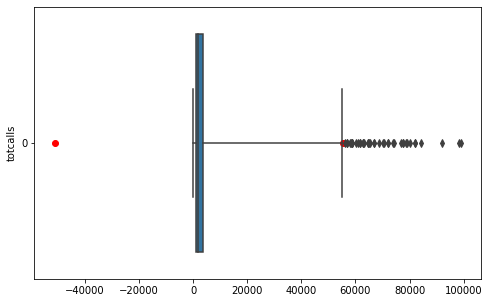

Lower limit of totcalls is -51171.0
Upper limit of totcalls is 55552.0


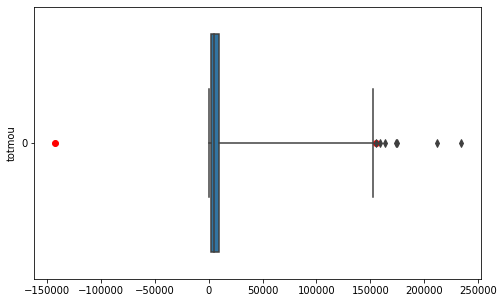

Lower limit of totmou is -142411.0
Upper limit of totmou is 154716.0


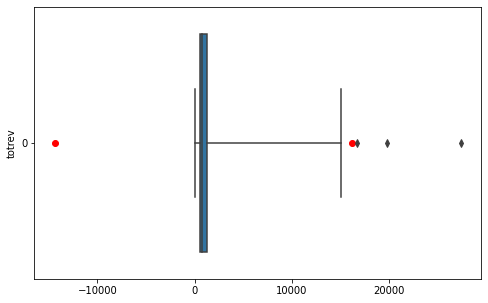

Lower limit of totrev is -14377.0
Upper limit of totrev is 16160.0


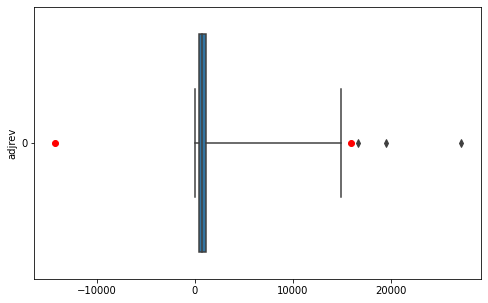

Lower limit of adjrev is -14268.0
Upper limit of adjrev is 15908.0


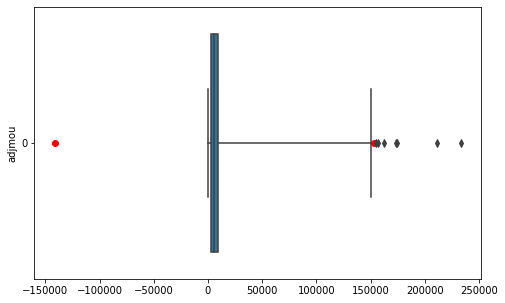

Lower limit of adjmou is -141266.0
Upper limit of adjmou is 153401.0


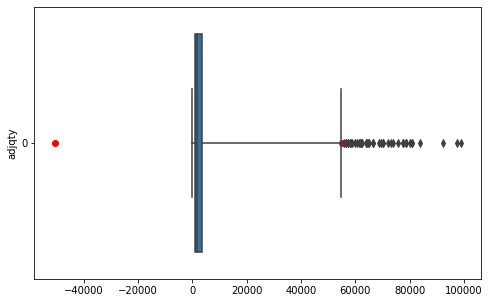

Lower limit of adjqty is -50612.0
Upper limit of adjqty is 54922.0


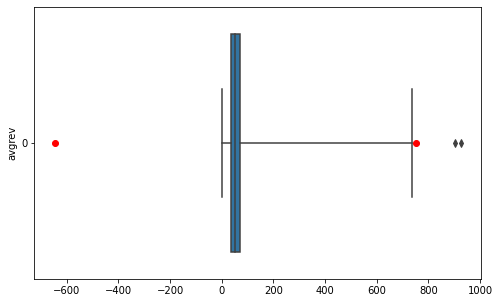

Lower limit of avgrev is -647.0
Upper limit of avgrev is 752.0


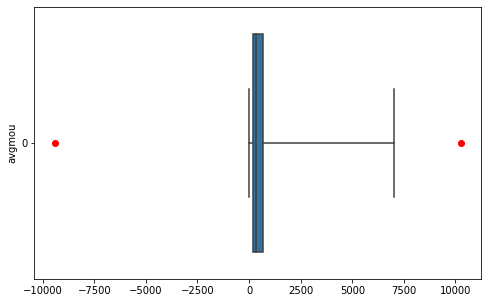

Lower limit of avgmou is -9414.0
Upper limit of avgmou is 10246.0


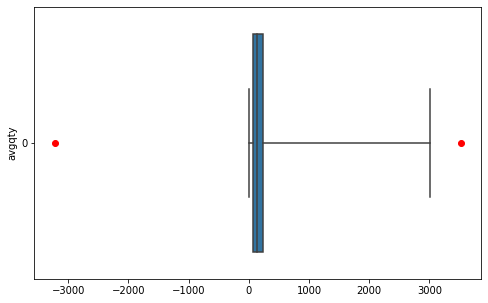

Lower limit of avgqty is -3226.0
Upper limit of avgqty is 3518.0


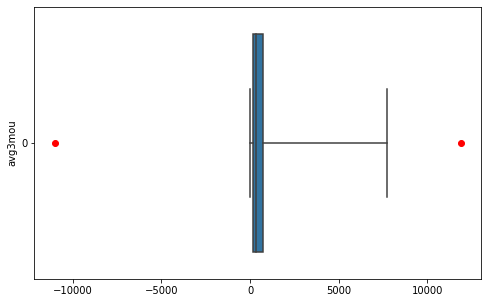

Lower limit of avg3mou is -11028.0
Upper limit of avg3mou is 11891.0


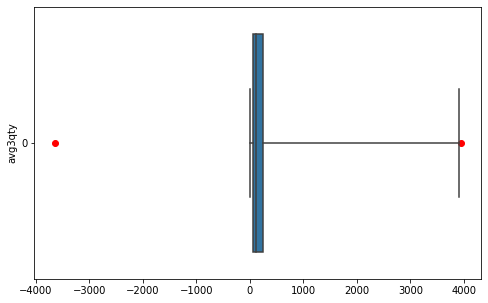

Lower limit of avg3qty is -3645.0
Upper limit of avg3qty is 3940.0


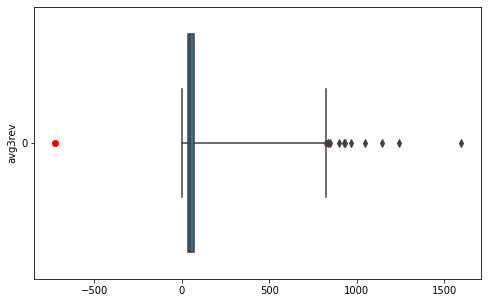

Lower limit of avg3rev is -727.0
Upper limit of avg3rev is 831.0


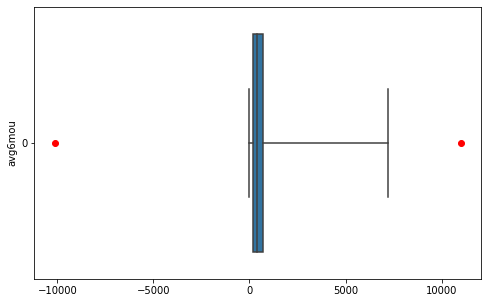

Lower limit of avg6mou is -10132.0
Upper limit of avg6mou is 10983.0


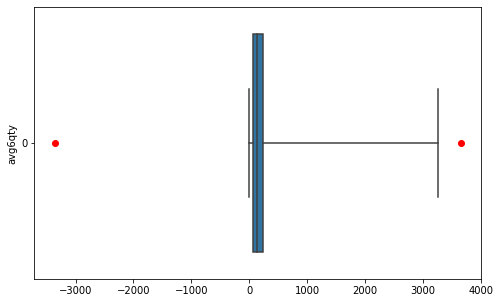

Lower limit of avg6qty is -3359.0
Upper limit of avg6qty is 3652.0


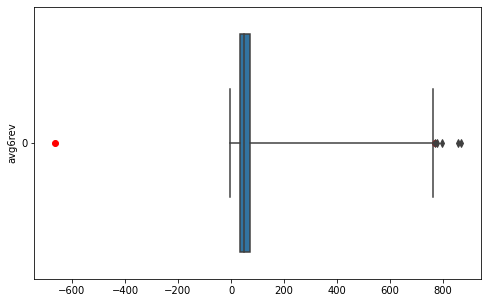

Lower limit of avg6rev is -665.0
Upper limit of avg6rev is 770.0


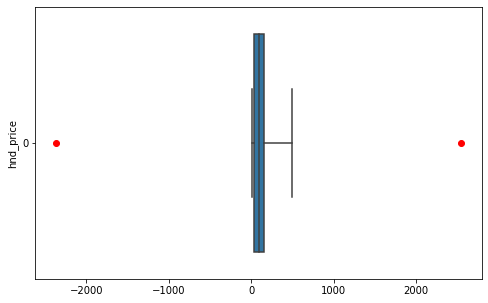

Lower limit of hnd_price is -2370.0
Upper limit of hnd_price is 2550.0


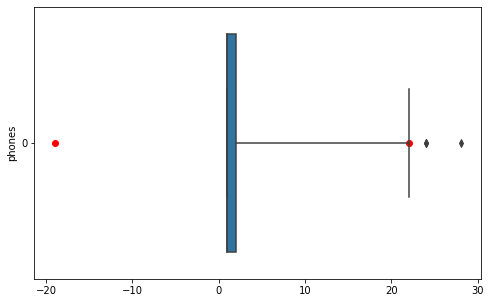

Lower limit of phones is -19.0
Upper limit of phones is 22.0


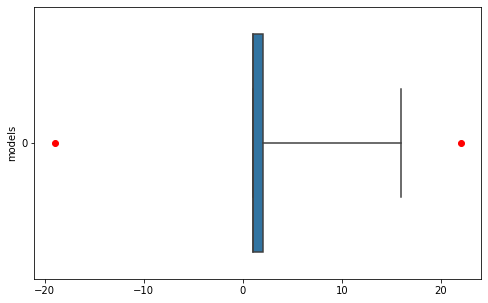

Lower limit of models is -19.0
Upper limit of models is 22.0


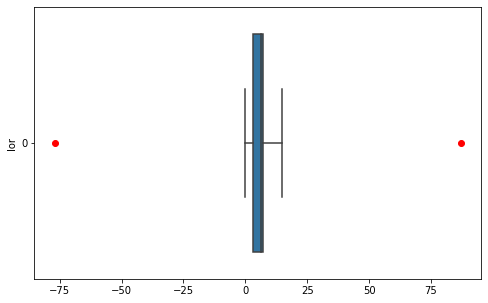

Lower limit of lor is -77.0
Upper limit of lor is 87.0


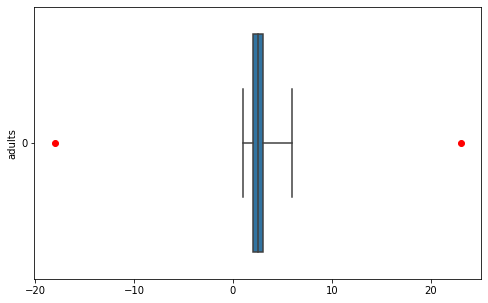

Lower limit of adults is -18.0
Upper limit of adults is 23.0


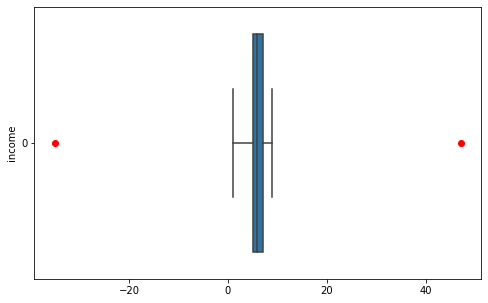

Lower limit of income is -35.0
Upper limit of income is 47.0


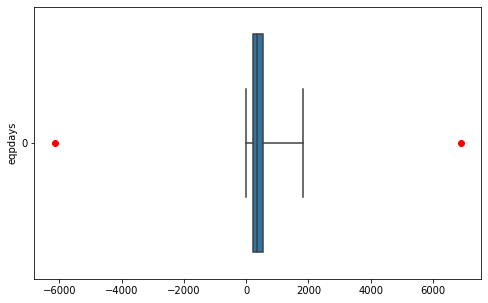

Lower limit of eqpdays is -6148.0
Upper limit of eqpdays is 6890.0


In [17]:
# Almost all columns have outliers.
col_num = list(numerical_feat_final.columns)

dimentions = (8, 5)
whis = 20
df_outliers = pd.DataFrame(columns=['col_name', 'limit_upper', 'limit_lower', 'outlier_num', 'outlier_per'])

for col in col_num:
    
    fig, ax = plt.subplots(figsize = dimentions)
    q1 = numerical_feat_final[col].quantile(0.25)
    q3 = numerical_feat_final[col].quantile(0.75)
    iqr = q3 - q1
    limit_lower = q1 - whis*iqr
    limit_upper = q3 + whis*iqr
    sns.boxplot(data = numerical_feat_final[col], orient = "h", whis = whis)
    plt.scatter(limit_lower, 0, color = 'red')
    plt.scatter(limit_upper, 0, color = 'red')
    plt.ylabel(col)
    plt.show()
    
    print("Lower limit of" , col , "is" , round(limit_lower))
    print("Upper limit of" , col , "is" , round(limit_upper))
    
    outliers_num = numerical_feat_final[(numerical_feat_final[col] > limit_upper) | (numerical_feat_final[col] < limit_lower)].shape[0]
    outliers_per = outliers_num / numerical_feat_final.shape[0] * 100
    df_outliers = df_outliers.append({'col_name': col, 'limit_upper': round(limit_upper),'limit_lower': round(limit_lower), 'outlier_num': outliers_num, 'outlier_per': outliers_per}, ignore_index = True)

In [18]:
#Ouliers that are to be removed:
#This outliers represent around 5% of the data. We are not going to remove them, because I think it's to much (for now).
outliers = df_outliers[(df_outliers.outlier_per <= 1) & (df_outliers.outlier_per > 0)]
outliers

,col_name,limit_upper,limit_lower,outlier_num,outlier_per
0,rev_Mean,817.0,-713.0,8,0.008
1,mou_Mean,11696.0,-10844.0,1,0.001
3,da_Mean,19.0,-18.0,167,0.167
4,ovrmou_Mean,882.0,-840.0,175,0.175
5,ovrrev_Mean,301.0,-287.0,110,0.110
6,vceovr_Mean,293.0,-279.0,113,0.113
9,change_mou,3017.0,-3041.0,10,0.010
10,change_rev,177.0,-182.0,640,0.640
11,drop_vce_Mean,148.0,-139.0,10,0.010
13,blck_vce_Mean,77.0,-73.0,359,0.359


In [19]:
#Decide how many categorical features to use
#See the correlation between the numerical variables
numerical_means = numerical_feat_final[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 
                                        'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean',
                                        'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean',
                                        'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 
                                        'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean']]


numerical_avg = numerical_feat_final[['adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev']]

In [20]:
def heatmap(corr_data):
    plt.figure(figsize = (35,20))
    sns.heatmap(data = corr_data, annot = True, cmap = plt.cm.Reds, fmt = '.1')
    plt.show()

In [21]:
sperman_corr_mean_data = numerical_means.corr(method = 'spearman')

sperman_corr_avg_data = numerical_avg.corr(method = 'spearman')

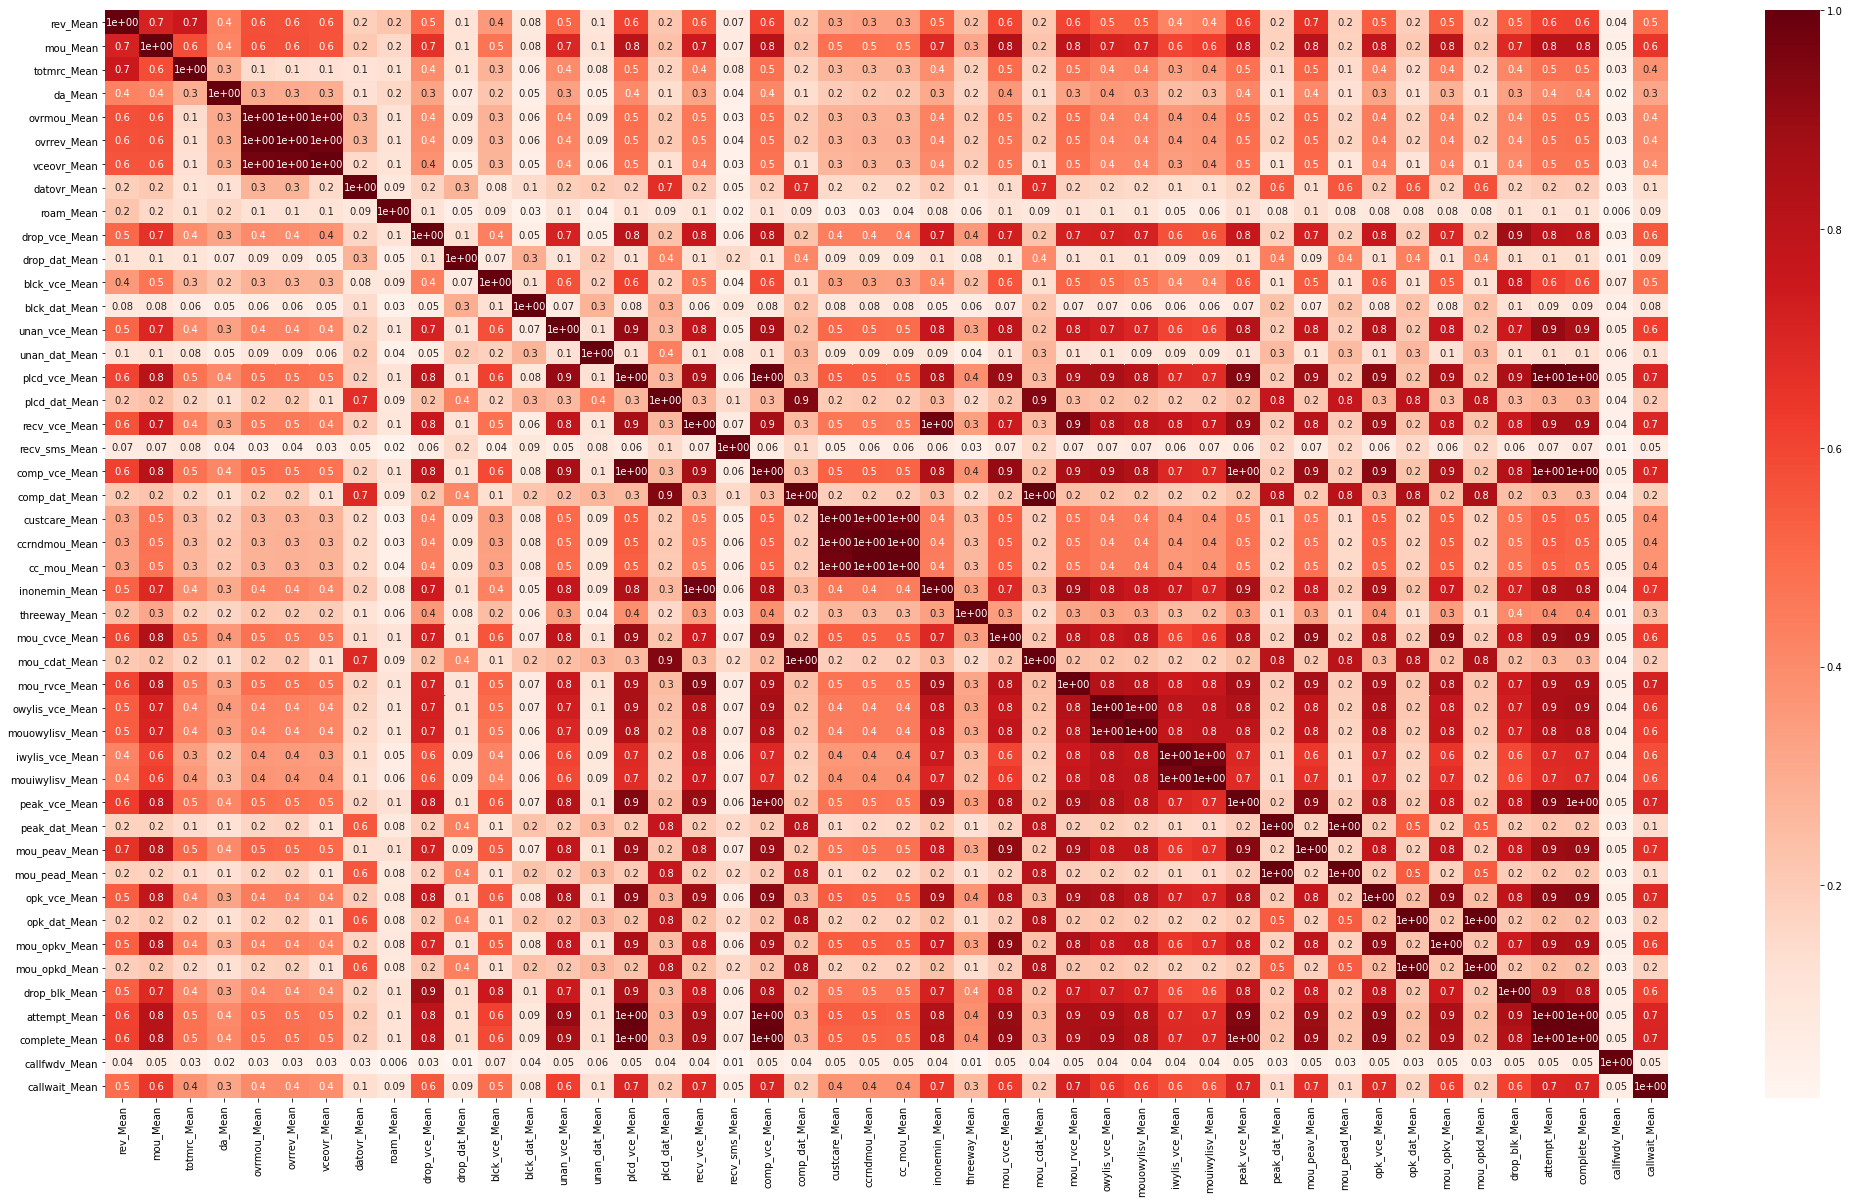

In [22]:
heatmap(sperman_corr_mean_data)
#After evaluating the heatmap we can see that lots of variable have correlation of 1, which means they explain each other. 
#Therefore we can remove the columns: ovrmou_Mean, vceovr_Mean, recv_vce_Mean, comp_vce_Mean, ccrndmou_Mean, cc_mou_Mean, mou_cdat_Mean, owylis_vce_Mean, iwylis_vce_Mean, mou_pead_Mean,
#mou_opkd_Mean, attempt_Mean and complete_Mean.

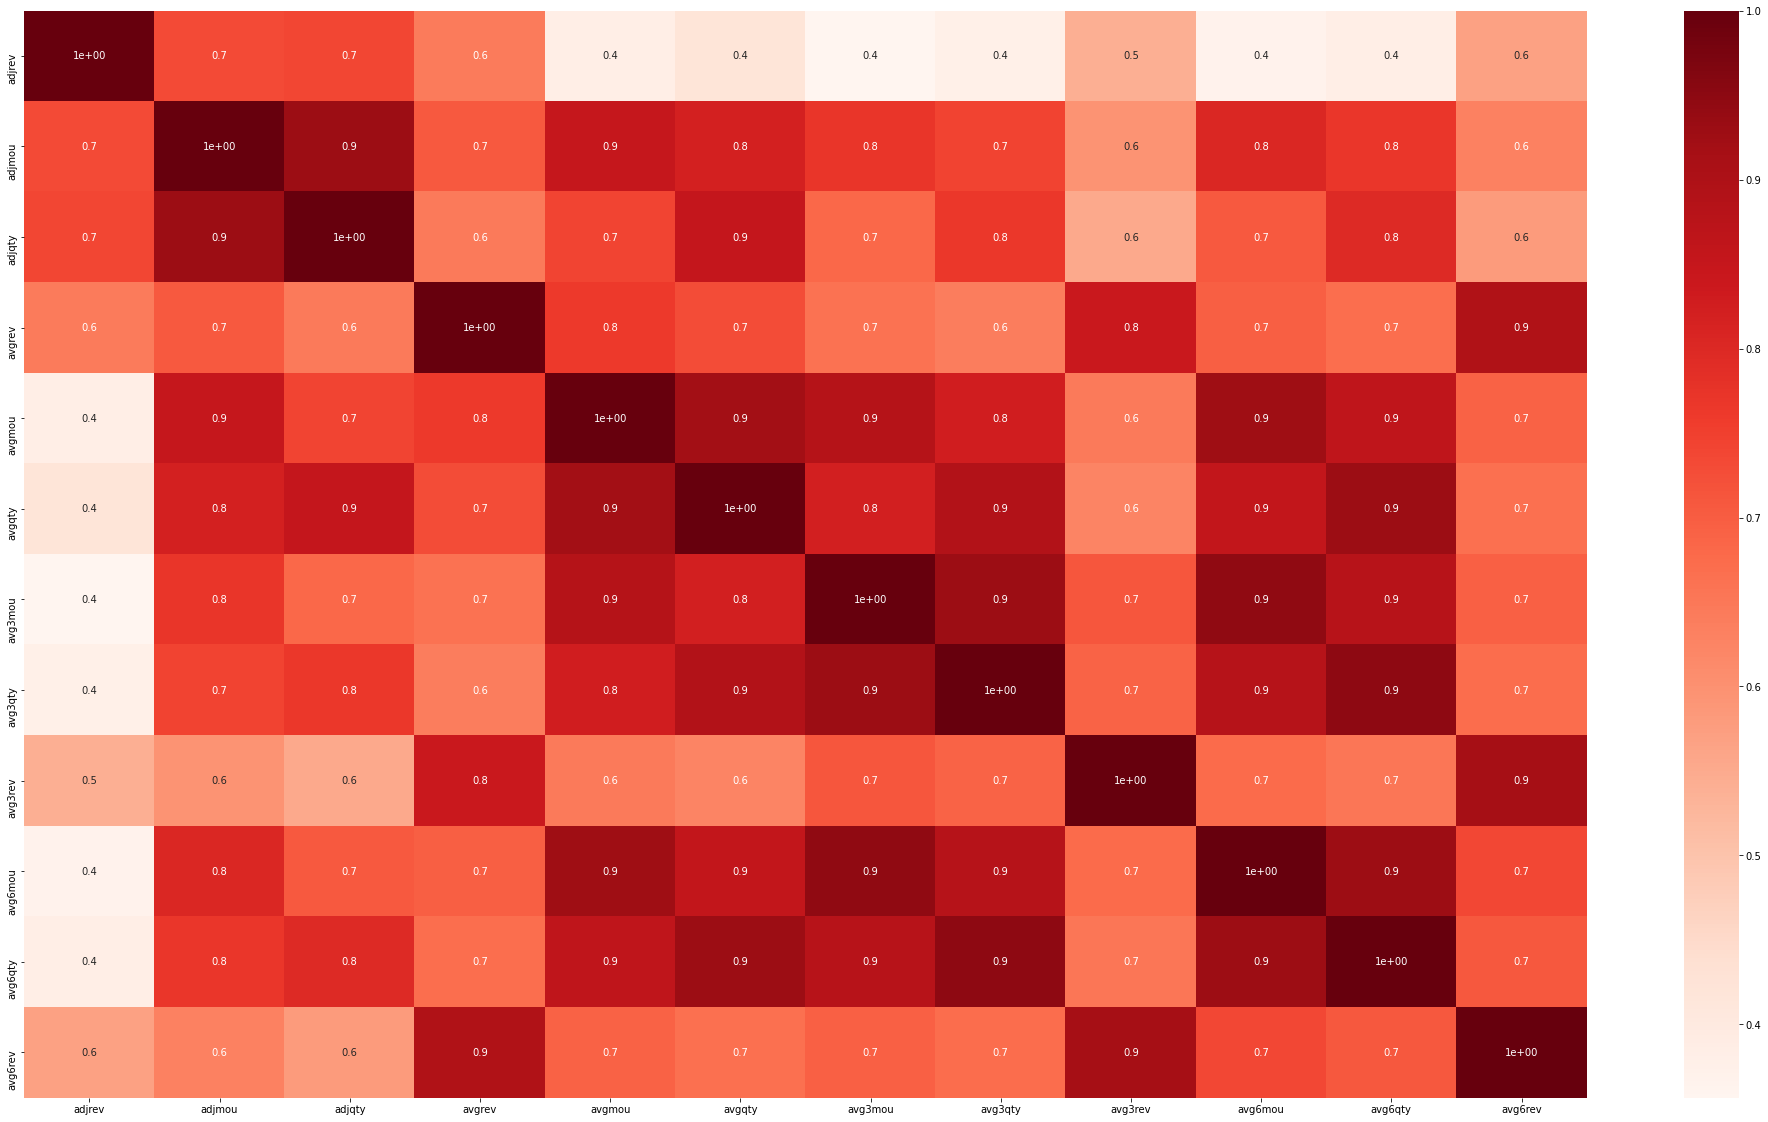

In [23]:
heatmap(sperman_corr_avg_data)
#We are not going to remove any of the avg variables for now.

In [25]:
#Now, let's check if the remaining mean variables are correlated with the avg ones:
sperman_corr_all_data = numerical_feat_final[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrrev_Mean', 'datovr_Mean', 'roam_Mean', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
                                              'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_sms_Mean', 'comp_dat_Mean', 'custcare_Mean', 'inonemin_Mean',
                                              'threeway_Mean', 'mou_cvce_Mean',  'mou_rvce_Mean',  'mouowylisv_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'opk_vce_Mean',
                                              'opk_dat_Mean', 'mou_opkv_Mean', 'drop_blk_Mean', 'callfwdv_Mean', 'callwait_Mean', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty',
                                              'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev']]

sperman_all_data = sperman_corr_all_data.corr(method = 'spearman')

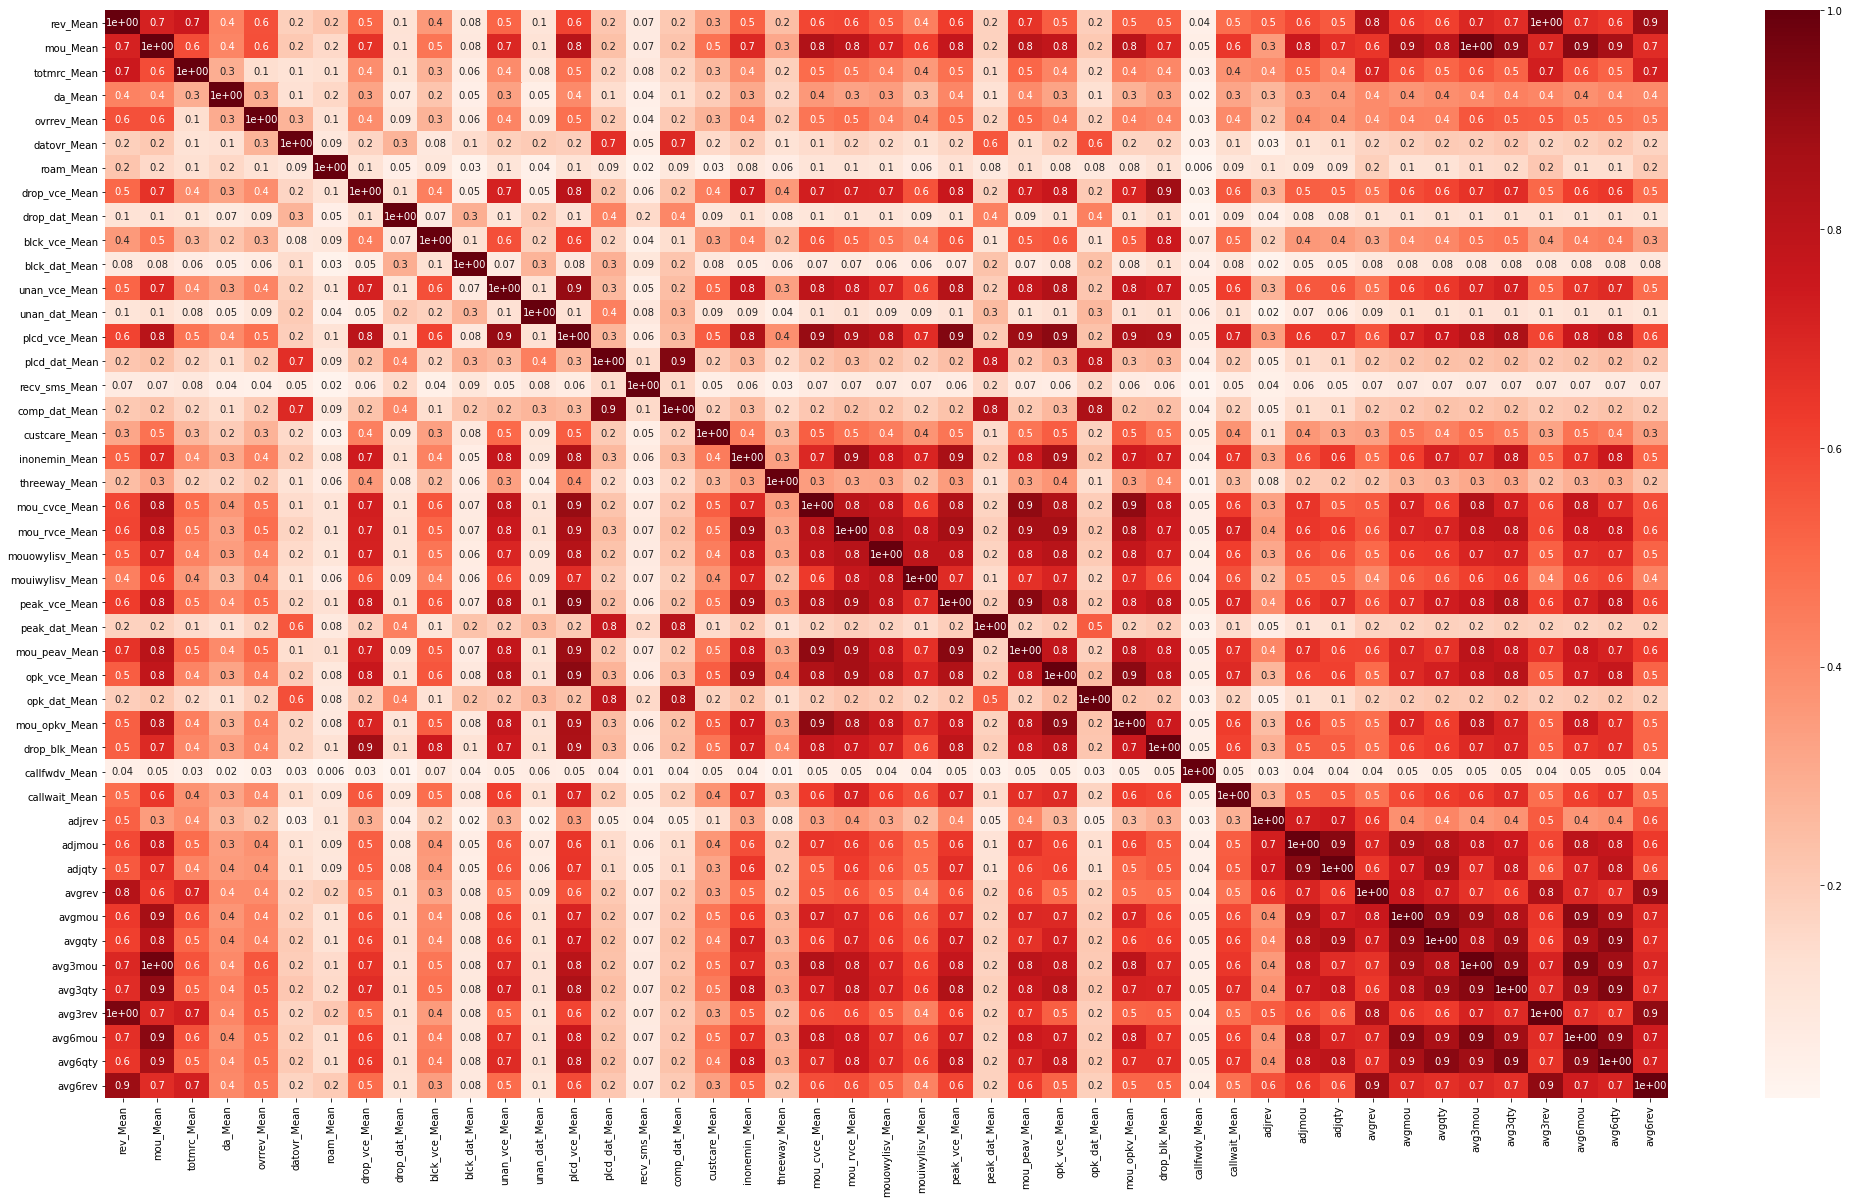

In [26]:
#We can also remove avg_3mou and avg_3rev as they have correlation of 1 with rev_Mean and mou_Mean respectively.
heatmap(sperman_all_data)

In [27]:
numerical_feat_final = numerical_feat_final[['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean','ovrrev_Mean', 'datovr_Mean', 'roam_Mean', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 
                                             'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_sms_Mean', 'comp_dat_Mean', 'custcare_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean',
                                             'mou_rvce_Mean', 'mouowylisv_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'drop_blk_Mean',
                                             'callfwdv_Mean', 'callwait_Mean', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty','avg3qty','avg6mou', 'avg6qty', 'avg6rev']]

numerical_feat_final.shape
#from now on we keep going with 43 numerical variables.

(100000, 43)

In [28]:
#Let's encode the categorical variables
encoder = preprocessing.LabelEncoder()

In [29]:
categorical_feat_final = categorical_feat_final.apply(encoder.fit_transform)
#categorical_feat_final.head()

In [30]:
#Let's now find out what are the best features to predict the target variable.
#Let's start by the numerical variables.
#Because the input is numerical and the output is categorical we are going to implement ANOVA algorithm.

X_numerical = numerical_feat_final.to_numpy()

y_target = target.to_numpy()

In [31]:
#Creates a SelectKBest object to select features with two best ANOVA F-Values
model = SelectKBest(f_classif, k = 'all')

#Applies the SelectKBest object to the features and target
best = model.fit_transform(X_numerical, y_target)

p_values = model.pvalues_
scores = model.scores_
print("p-values: ", p_values)
print("Scores: ", scores)

p-values:  [5.91835091e-004 1.47225151e-072 4.30234274e-104 1.88923143e-005
 6.70430172e-014 6.83934682e-001 3.24804147e-003 1.39104176e-006
 4.90737400e-002 4.32690106e-003 2.04129638e-001 2.35440977e-029
 1.35002291e-001 9.01734296e-053 2.66571066e-003 7.97462105e-001
 4.97249410e-003 1.14635013e-030 9.78351657e-028 3.11156889e-022
 6.23292545e-061 2.53406078e-050 2.34755847e-028 1.60787515e-028
 9.06764334e-053 1.65363303e-002 1.30758549e-050 7.88219165e-052
 4.89634226e-003 5.42205911e-054 5.36473407e-007 4.77098692e-001
 8.24861789e-023 3.59119668e-001 2.94844446e-008 2.72027667e-007
 5.49235436e-003 3.02024303e-014 5.82442559e-014 7.97035915e-044
 5.81140679e-043 9.68099060e-034 5.05340197e-009]
Scores:  [1.18022400e+01 3.25087403e+02 4.70517922e+02 1.82995867e+01
 5.61691147e+01 1.65731222e-01 8.66303743e+00 2.32958459e+01
 3.87292331e+00 8.14164034e+00 1.61260017e+00 1.26610507e+02
 2.23405503e+00 2.34035983e+02 9.02367442e+00 6.58608426e-02
 7.88976584e+00 1.32617264e+02 1.192

In [32]:
X_indices = np.arange(X_numerical.shape[-1])

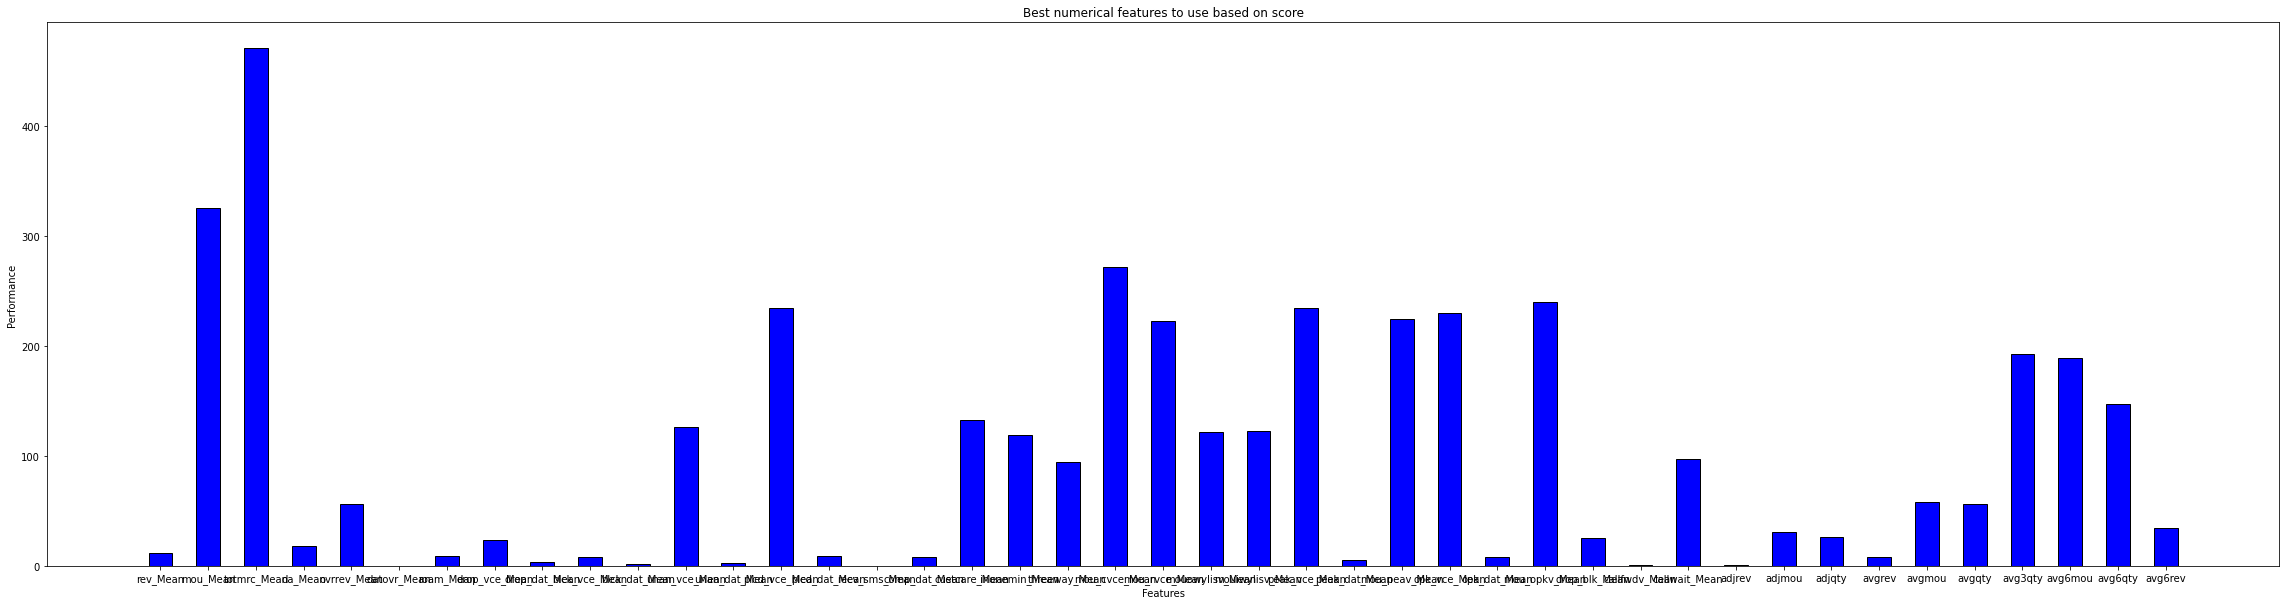

In [33]:
fig, ax = plt.subplots(figsize = (40, 10))

x = numerical_feat_final.columns
x_pos = [i for i, _ in enumerate(x)]

plt.bar(X_indices, scores, width = 0.5, color = 'blue', edgecolor = 'black')
plt.title('Best numerical features to use based on score')
plt.xticks(x_pos, x)
plt.ylabel('Performance')
plt.xlabel('Features')
plt.show()

In [34]:
#Let's now see what are the best categorical feature to predict the target variable.
#Because the input is categorical and the output is categorical we are going to implement chi-squared algorithm.

X_categorical = categorical_feat_final.to_numpy()

model = SelectKBest(chi2, k = 'all') 
best = model.fit_transform(X_categorical, y_target) 

p_values = model.pvalues_
scores = model.scores_
print("p-values: ", p_values)
print("Scores: ", scores)

p-values:  [4.71886010e-01 0.00000000e+00 2.45762841e-92 2.88021044e-01
 3.54249168e-14 9.83111898e-21 1.40369616e-20 5.16016913e-05
 2.82273425e-01 8.40860445e-01 3.29568894e-02 6.17413799e-01
 4.78995344e-04 7.53482771e-07 1.41041524e-01 1.50312232e-20
 2.76646603e-03 2.81725191e-01]
Scores:  [5.17556184e-01 1.80371857e+03 4.15391673e+02 1.12884871e+00
 5.74075260e+01 8.71954201e+01 8.64910714e+01 1.63883399e+01
 1.15611159e+00 4.03178245e-02 4.54801725e+00 2.49519239e-01
 1.21957103e+01 2.44732615e+01 2.16655893e+00 8.63557319e+01
 8.95542643e+00 1.15874875e+00]


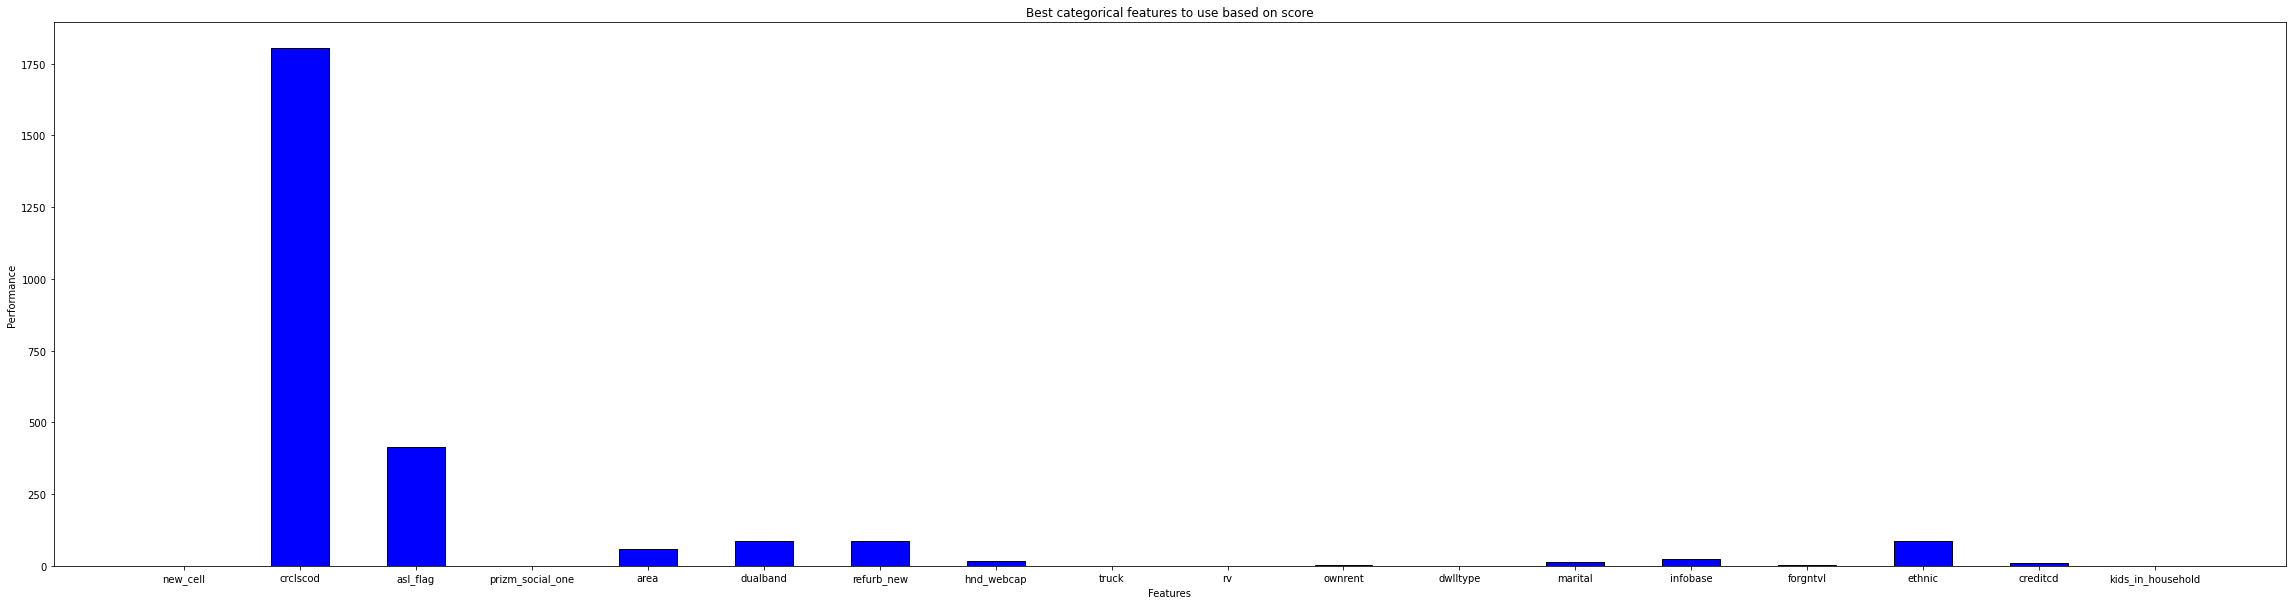

In [35]:
fig, ax = plt.subplots(figsize = (40, 10))

X_indices = np.arange(X_categorical.shape[-1])
x = categorical_feat_final.columns
x_pos = [i for i, _ in enumerate(x)]

plt.bar(X_indices, scores, width = 0.5, color = 'blue', edgecolor = 'black')
plt.title('Best categorical features to use based on score')
plt.xticks(x_pos, x)
plt.ylabel('Performance')
plt.xlabel('Features')
plt.show()

In [ ]:
#number of features
nof_list = np.arange(1, numerical_feat_final.shape[1])

high_score = 0

#Variable to store the optimum features
nof = 0           
score_list = []

for n in range(len(nof_list)):
    
    X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_target, test_size = 0.3, random_state = 42)
    
    model = RandomForestClassifier()
    #model = DecisionTreeClassifier()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)

    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    print(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]

0.5073333333333333
0.5157333333333334
0.5274666666666666
0.5488333333333333
0.5532
0.5611
0.5655
0.5647666666666666
0.5612666666666667
0.5671333333333334
0.5661
0.5665333333333333
0.5677
0.5683666666666667


In [ ]:
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
#Without outliers and DT: 42 features, 55%
#With outliers and DT: 34 features, 55%

#Without ouliers and RF:
#With outliers and RF: 63 features, 62%


#------
#After correlation evaluation:
#with outliers and DT: 26 features, 53%
#with outliers and RF:

In [26]:
#Now that we know how many festures give the best score, let's discover which ones.
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y_target, test_size = 0.3, random_state = 42)
    
#model = DecisionTreeClassifier()
model = RandomForestClassifier()
#We are not going to try logistic regression because this data has lots of outliers (to much to be removed in my opinion)
#and this algorithm is sensitive to outliers. - It will not perform well.

DecisionTreeClassifier()

In [ ]:
rfe = RFE(model, 42)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe, y_train)

In [51]:
selected_features = pd.DataFrame({"col_name": numerical_feat_final.columns, "to_be_used": rfe.support_})
selected_features

In [57]:
selected_features.loc[selected_features.to_be_used]

,col_name,to_be_used
0,rev_Mean,True
1,mou_Mean,True
2,totmrc_Mean,True
6,vceovr_Mean,True
7,change_mou,True
8,change_rev,True
9,drop_vce_Mean,True
10,blck_vce_Mean,True
11,unan_vce_Mean,True
12,plcd_vce_Mean,True


In [ ]:
#Decide how many categorical features to use